## Description
This is the cross correlation calculation result. The result should show below in the first graph (ignore the first 2). You might need to invoke the cell below here to see the graph.

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import analysis as an
import cross_correlation_analyzer as cca
import numpy as np
from scipy import signal

an.PREFIX = "david_alley.3.0m."

Frames to reach phone holder: 91.0
Time 0.017324263038548754
Speed of Sound 342.814
Distance 2.9694999546485263
------
Time 0.011904761904761904
Speed of Sound 342.814
Distance 2.0405595238095238
------
Time 0.015351473922902495
Speed of Sound 342.814
Distance 2.631350090702948
------
Time 0.012517006802721088
Speed of Sound 342.814
Distance 2.1455025850340137
------
Time 0.017324263038548754
Speed of Sound 342.814
Distance 2.9694999546485263
------
Time 0.01614512471655329
Speed of Sound 342.814
Distance 2.76738739229025
------
Time 0.017324263038548754
Speed of Sound 342.814
Distance 2.9694999546485263
------
Time 0.01671201814058957
Speed of Sound 342.814
Distance 2.8645568934240364
------
Time 0.017596371882086168
Speed of Sound 342.814
Distance 3.016141315192744
------
Time 0.01746031746031746
Speed of Sound 342.814
Distance 2.992820634920635
------
Time 0.017165532879818594
Speed of Sound 342.814
Distance 2.942292494331066
------
Time 0.0173015873015873
Speed of Sound 342.814
Dis

/home/david/uni/SonarApp_utils/analysis.py:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


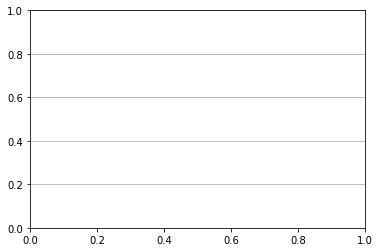

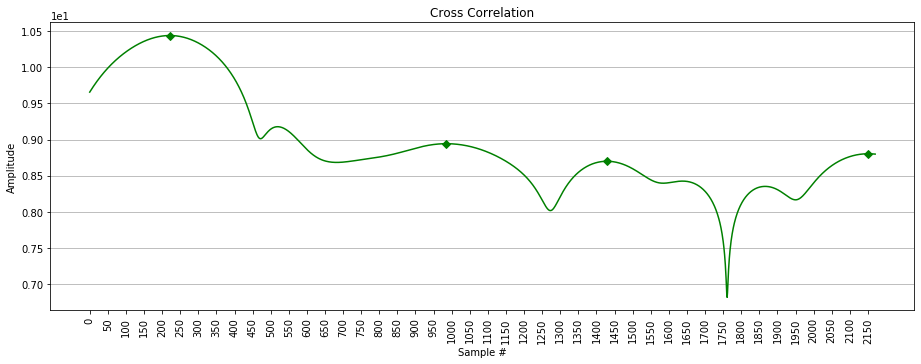

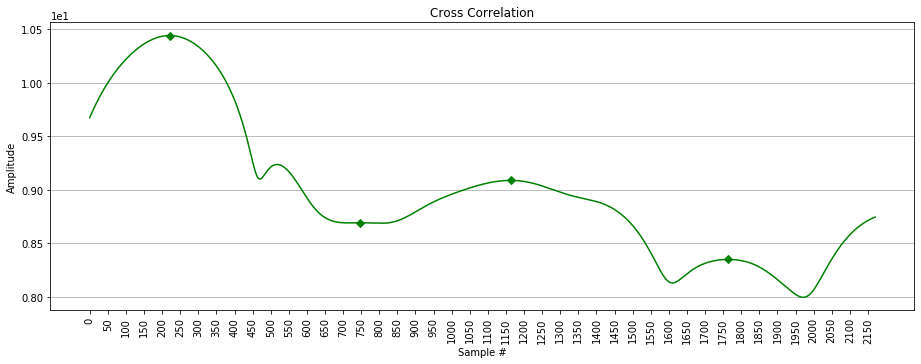

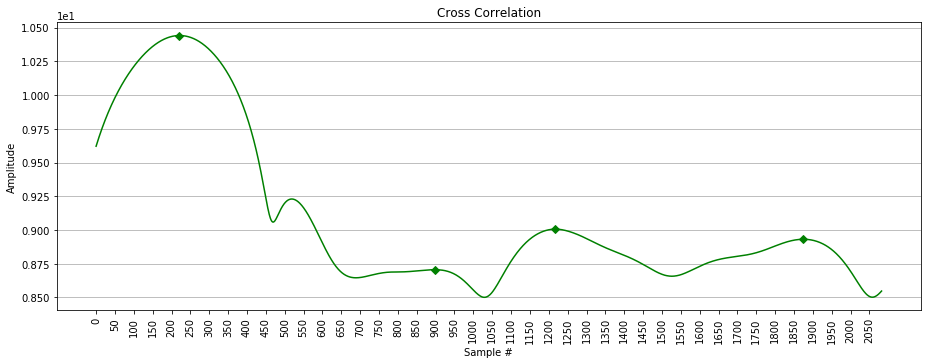

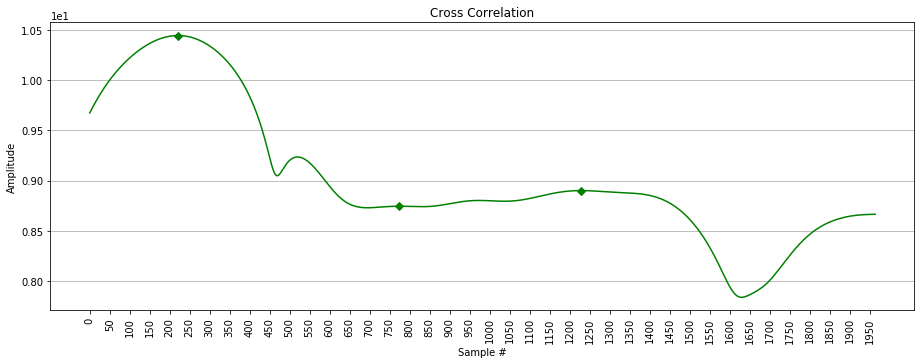

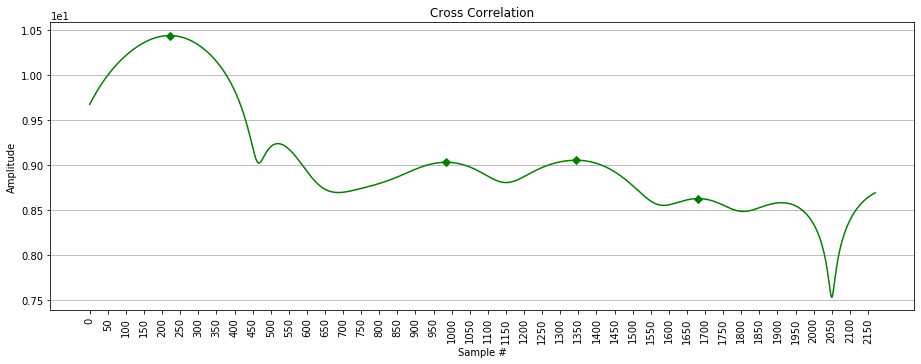

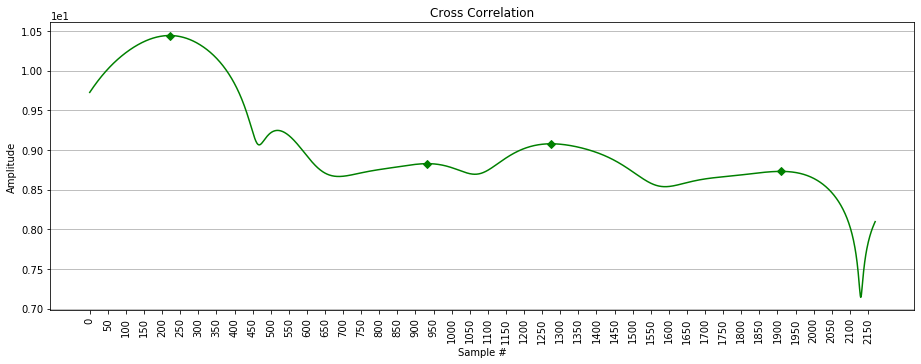

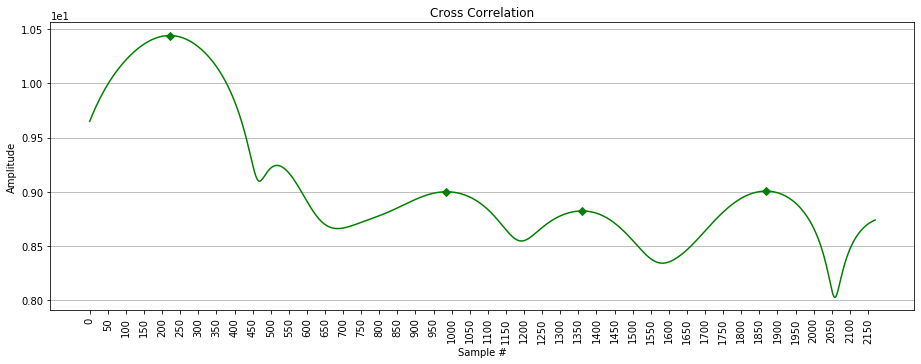

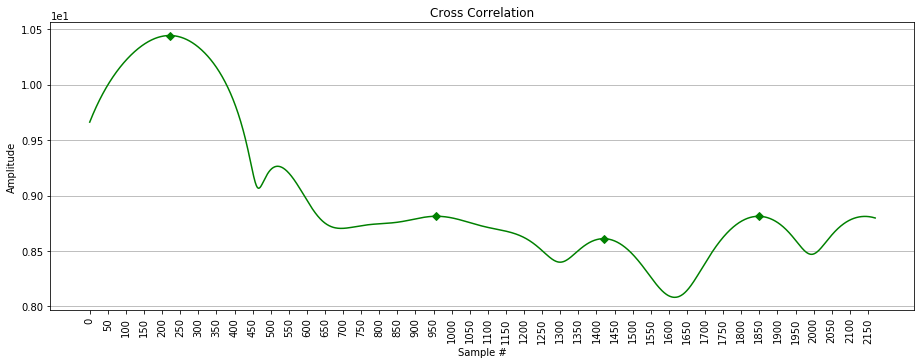

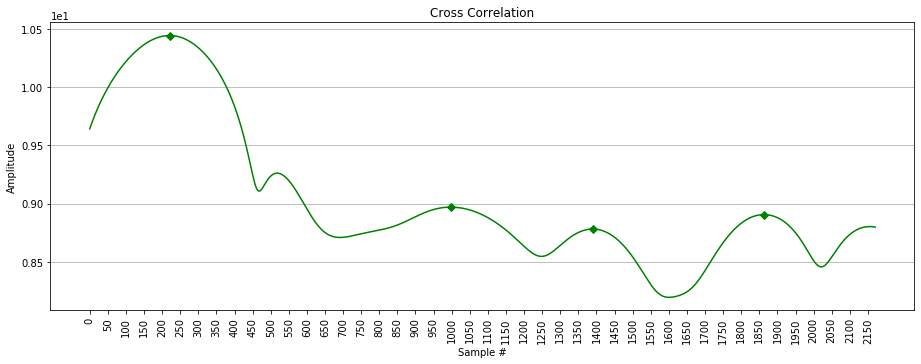

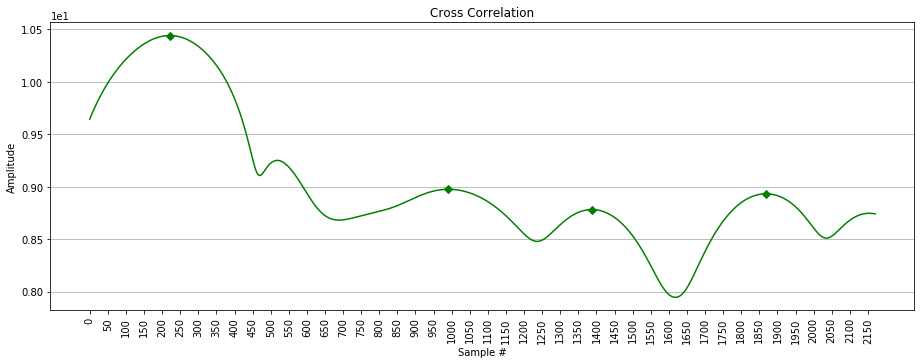

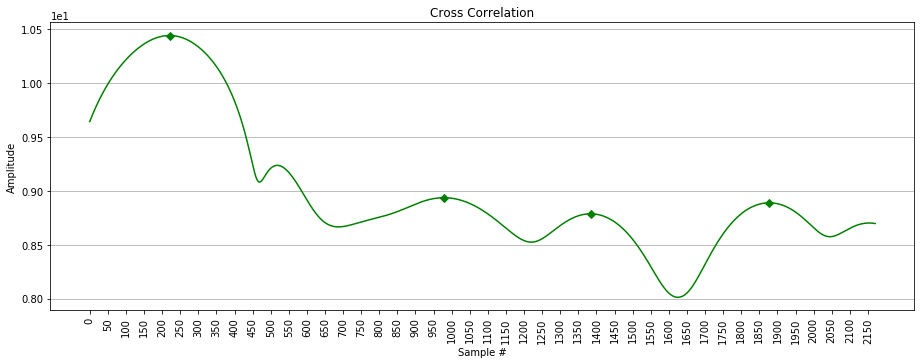

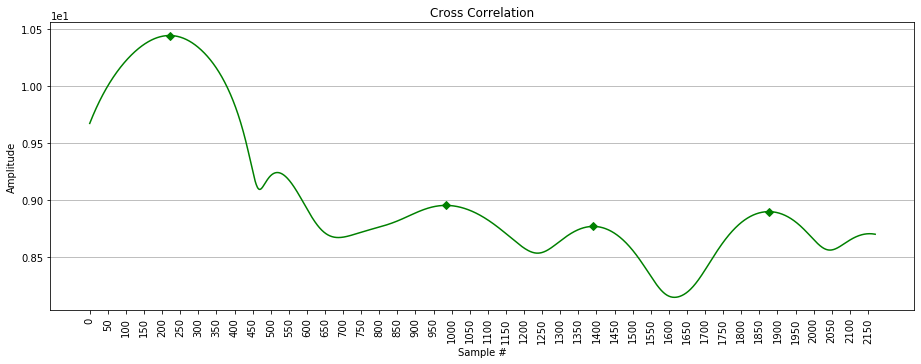

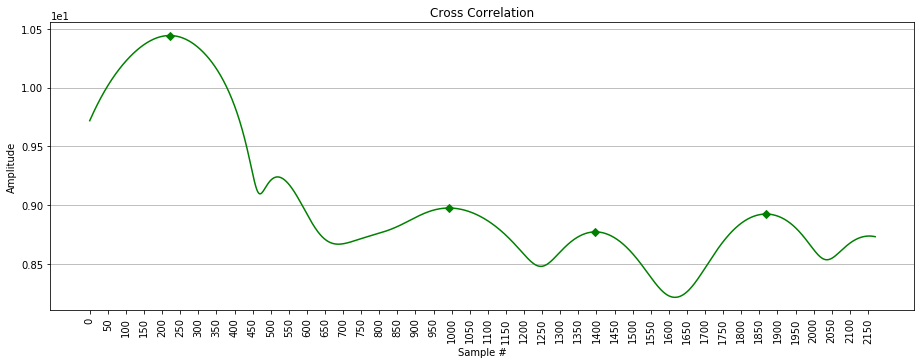

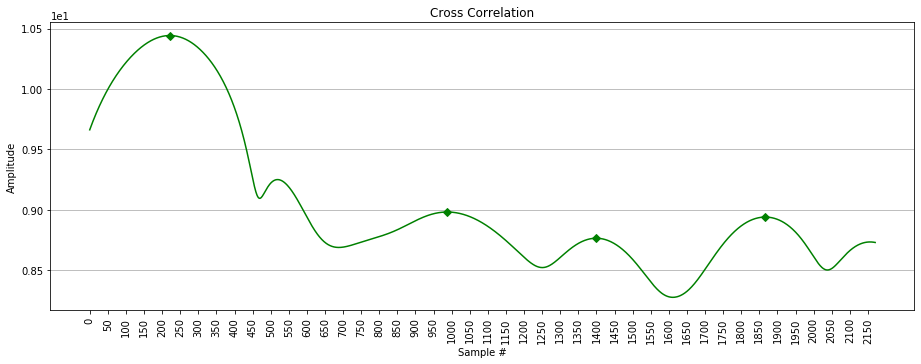

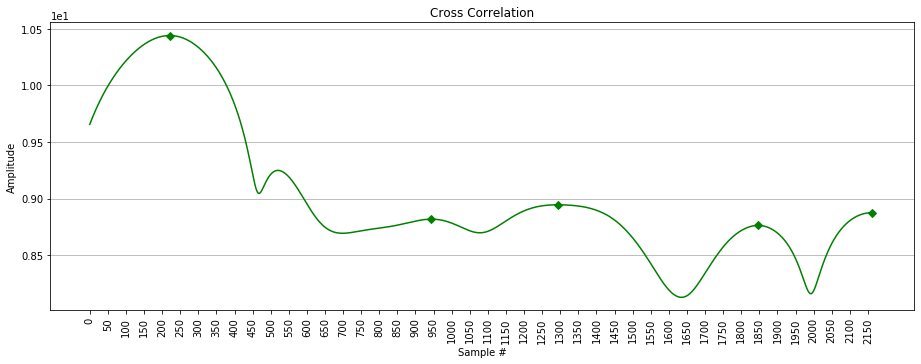

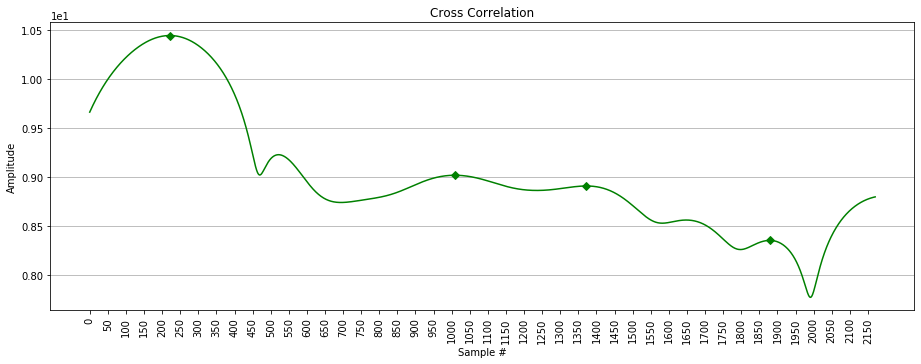

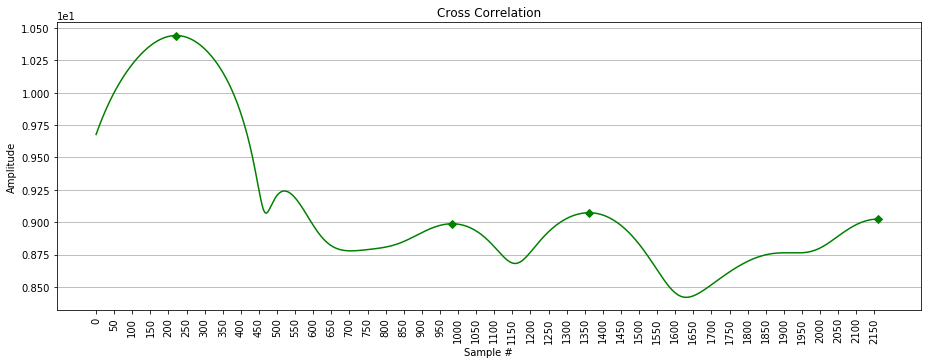

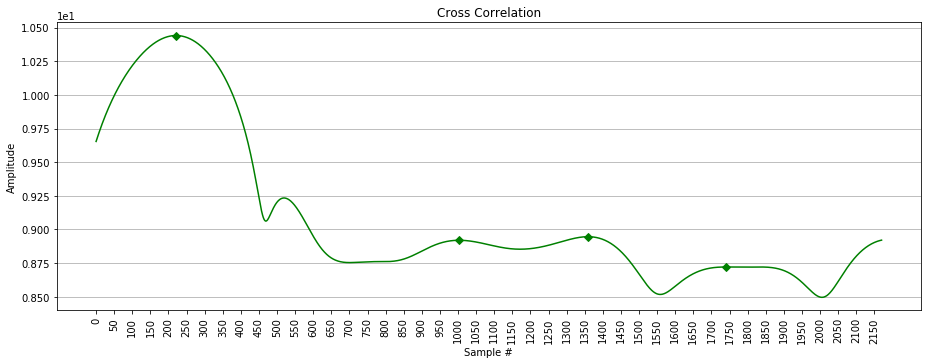

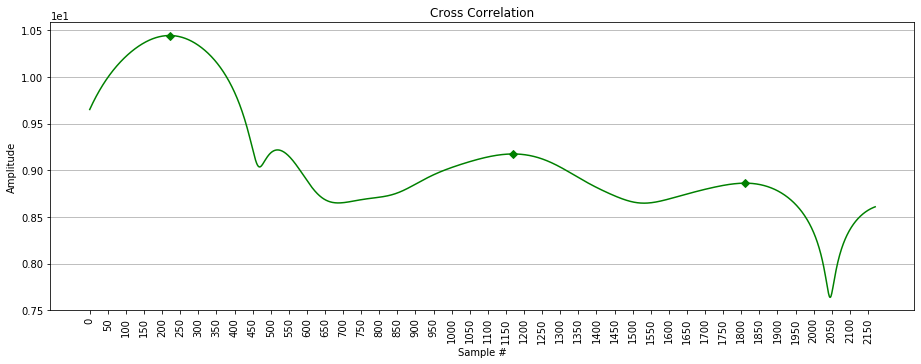

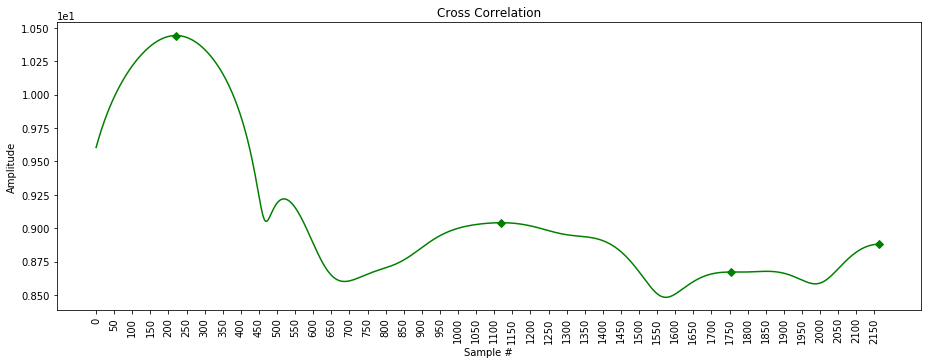

In [6]:
%matplotlib inline


temp=19
sound_of_speed = an.get_speed_of_sound(temp)
threshold = 10.0 ** 0.85
holder_distance = 0.35 
frames_to_reach_phone_holder = np.ceil(an.SAMPLE_RATE * (holder_distance * 2 / sound_of_speed))
print("Frames to reach phone holder: {0}".format(frames_to_reach_phone_holder))
distance=int(an.CHIRP_DURATION * an.SAMPLE_RATE * 0.5 + frames_to_reach_phone_holder)


distances = []
print_format = "Time {0}\nSpeed of Sound {1}\nDistance {2}"


for sample_number in range(1, 21):
    cc = cca.get_cc(sample_number)
    time_delta, speed_of_sound, half_distance, peaks = \
        cca.get_distances(cc, threshold, distance, temp)
    if half_distance:
        distances.append(half_distance)
#     print("Peaks: {}".format(["[{0}]={1:.1e}".format(p,cc[p]) for p in peaks]))
    print(print_format.format(time_delta, speed_of_sound, half_distance))
    logcc = [np.log10(c) for c in cc]
#     logcc = cc
    an.get_graph_figure(logcc, 'Cross Correlation', markers=peaks)
    print("------")

print("Avg distance: {}".format(np.mean(distances)))